In [1]:
%pip install rdkit joblib requests tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 54.1 MB/s eta 0:00:00


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import joblib
import warnings
import time
warnings.filterwarnings('ignore')

In [4]:
def load_dataset():
    data = {
        'smiles': [
            # Carboxylic Acids
            'CC(=O)O', 'C(=O)O', 'CCC(=O)O', 'CCCC(=O)O', 'CCCCC(=O)O',
            'CC(C)C(=O)O', 'CC(C)(C)C(=O)O', 'CCCCCCCC(=O)O', 'CCC(C)C(=O)O',
            'CC(C)CC(=O)O', 'CCCCCCCCCCCC(=O)O', 'C=CC(=O)O', 'CC(Cl)C(=O)O',
            # Aromatic Carboxylic Acids
            'C1=CC=CC=C1C(=O)O', 'C1=CC(=CC=C1C(=O)O)O', 'C1=CC=C(C=C1)C(=O)O',
            'C1=CC=C(C(=C1)C(=O)O)O', 'C1=CC=C2C(=C1)C=CC=C2C(=O)O',
            # Dicarboxylic Acids
            'C(C(=O)O)C(=O)O', 'C(CC(=O)O)C(=O)O', 'C(CCC(=O)O)C(=O)O',
            'CC(CC(=O)O)C(=O)O', 'OC(=O)C(O)C(O)C(=O)O',
            # Hydroxy Acids
            'CC(O)C(=O)O', 'O=C(O)CO', 'CC(O)(C(=O)O)C(=O)O',
            # Sulfonic and Phosphoric Acids
            'O=S(=O)(O)O', 'O=P(O)(O)O', 'C1=CC=C(C=C1)S(=O)(=O)O',
            'CS(=O)(=O)O', 'CC(=O)CS(=O)(=O)O',
            # Phenols
            'C1=CC=C(C=C1)O', 'CC1=CC=C(C=C1)O', 'CC(C)C1=CC=C(C=C1)O',
            # Keto Acids
            'CC(=O)C(=O)O', 'CC(=O)C(C)C(=O)O', 'O=C(O)C(=O)C(=O)O',

            # Primary Amines (Bases)
            'CCN', 'CCCN', 'CCCCN', 'CCCCCCN', 'CN', 'CC(C)N',
            'C1CCCCC1N', 'CC(C)(C)N',
            # Secondary Amines
            'CNC', 'CNCC', 'CCNC', 'CCCNC', 'C1CCNCC1',
            # Tertiary Amines
            'CN(C)C', 'CCN(CC)CC', 'CN(C)CC', 'CN(CC)CC',
            # Diamines
            'NCCN', 'NCCCN', 'NCCCCN', 'C1CNCCN1',
            # Aromatic Amines
            'C1=CC=C(C=C1)N', 'C1=CC=C(N)C=C1', 'C1=CC=C(C=C1)NC',
            'CC1=CC=C(C=C1)N', 'C1=CC2=C(C=C1)NC=N2',
            # Pyridines and Related
            'C1=CC=NC=C1', 'C1=CC=CC=N1', 'C1=CN=CC=C1', 'C1=NC=CN1',
            'CC1=CC=NC=C1', 'C1=CC(=NC=C1)N', 'C1=NC2=C(N1)C=NC=N2',
            # Imidazoles
            'C1=CN=CN1', 'CC1=NC=CN1', 'C1=C(NC=N1)C',
            # Guanidines and Amidines
            'NC(N)=N', 'NC(=N)N', 'CC(=N)N',
            # Amino Alcohols
            'NCCO', 'NCC(C)O', 'C(CO)N',
            # Heterocyclic Amines
            'C1CCNC1', 'C1COCCN1', 'C1COCCO1',
            # Aniline Derivatives
            'C1=CC=C(C=C1)NCC', 'C1=CC=C(C=C1)N(C)C',
        ],
        'label': [
            # Acids (0) - 40 acids
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  # Carboxylic
            0, 0, 0, 0, 0,  # Aromatic carboxylic
            0, 0, 0, 0, 0,  # Dicarboxylic
            0, 0, 0,  # Hydroxy acids
            0, 0, 0, 0, 0,  # Sulfonic/Phosphoric
            0, 0, 0,  # Phenols
            0, 0, 0,  # Keto acids

            # Bases (1) - 60 bases
            1, 1, 1, 1, 1, 1, 1, 1,  # Primary amines
            1, 1, 1, 1, 1,  # Secondary amines
            1, 1, 1, 1,  # Tertiary amines
            1, 1, 1, 1,  # Diamines
            1, 1, 1, 1, 1,  # Aromatic amines
            1, 1, 1, 1, 1, 1, 1,  # Pyridines
            1, 1, 1,  # Imidazoles
            1, 1, 1,  # Guanidines
            1, 1, 1,  # Amino alcohols
            1, 1, 1,  # Heterocyclic
            1, 1,  # Aniline derivatives
        ]
    }

    df = pd.DataFrame(data)
    df['class'] = df['label'].map({0: 'Acid', 1: 'Base'})

    print(f"\nusing curated dataset with {len(df)} molecules")
    return df

df = load_dataset()

print(f"\ndataset statistics:")
print(f"total molecules: {len(df)}")
print(f"acids: {sum(df['label']==0)} ({sum(df['label']==0)/len(df)*100:.1f}%)")
print(f"bases: {sum(df['label']==1)} ({sum(df['label']==1)/len(df)*100:.1f}%)")
print("\nsample molecules:")
print(df[['smiles', 'class']].head(10))


using curated dataset with 84 molecules

dataset statistics:
total molecules: 84
acids: 37 (44.0%)
bases: 47 (56.0%)

sample molecules:
           smiles class
0         CC(=O)O  Acid
1          C(=O)O  Acid
2        CCC(=O)O  Acid
3       CCCC(=O)O  Acid
4      CCCCC(=O)O  Acid
5     CC(C)C(=O)O  Acid
6  CC(C)(C)C(=O)O  Acid
7   CCCCCCCC(=O)O  Acid
8    CCC(C)C(=O)O  Acid
9    CC(C)CC(=O)O  Acid


In [5]:
def extract_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    features = {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
        'NumAromaticRings': Descriptors.NumAromaticRings(mol),
        'NumSaturatedRings': Descriptors.NumSaturatedRings(mol),
        'NumAliphaticRings': Descriptors.NumAliphaticRings(mol),
        'RingCount': Descriptors.RingCount(mol),
        'FractionCSP3': Descriptors.FractionCSP3(mol),
        'NumHeteroatoms': Descriptors.NumHeteroatoms(mol),
    }
    return features

features_list = []
for smiles in df['smiles']:
    feat = extract_features(smiles)
    if feat:
        features_list.append(feat)
    else:
        features_list.append({k: 0 for k in features_list[0].keys()})

features_df = pd.DataFrame(features_list)
print(f"\nextracted {len(features_df.columns)} features:")
print(features_df.columns.tolist())
print("\nfeature statistics:")
print(features_df.describe())


extracted 12 features:
['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings', 'RingCount', 'FractionCSP3', 'NumHeteroatoms']

feature statistics:
            MolWt       LogP  NumHDonors  NumHAcceptors        TPSA  \
count   84.000000  84.000000   84.000000      84.000000   84.000000   
mean    93.884048   0.471148    1.226190       1.404762   37.811190   
std     30.825157   1.042457    0.766013       0.642267   23.516921   
min     31.058000  -2.122600    0.000000       1.000000    3.240000   
25%     73.139000  -0.322000    1.000000       1.000000   21.002500   
50%     89.116000   0.445350    1.000000       1.000000   37.300000   
75%    110.422000   1.117100    2.000000       2.000000   52.622500   
max    200.322000   3.991900    4.000000       4.000000  115.060000   

       NumRotatableBonds  NumAromaticRings  NumSaturatedRings  \
count          84.000000         84.000000          84.000000  

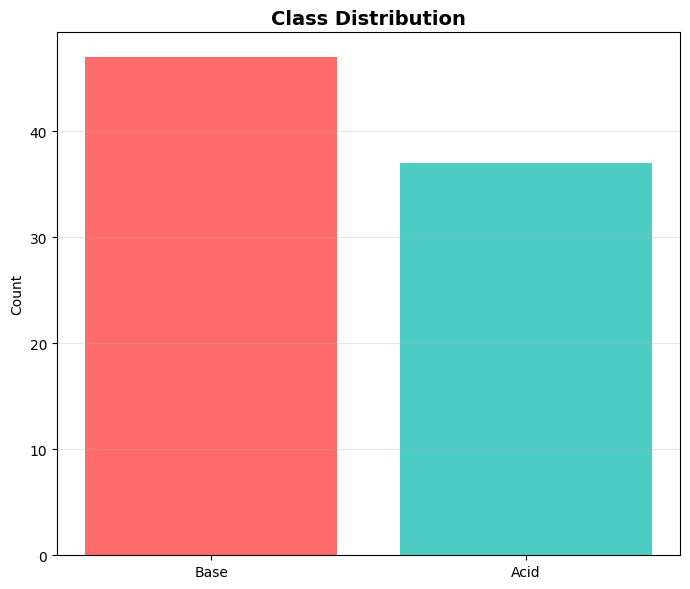

In [12]:
plt.figure(figsize=(7, 6))

class_counts = df['class'].value_counts()
plt.bar(class_counts.index, class_counts.values, color=['#ff6b6b', '#4ecdc4'])
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
X = features_df
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\ntraining random forest...")
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)

cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f"\ncross-validation scores: {cv_scores}")
print(f"mean cv score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)

print("\nclassification report:")
print(classification_report(y_test, y_pred, target_names=['Acid', 'Base']))


training random forest...

cross-validation scores: [0.85714286 0.78571429 0.76923077 0.84615385 1.        ]
mean cv score: 0.8516 (+/- 0.0815)

classification report:
              precision    recall  f1-score   support

        Acid       0.70      1.00      0.82         7
        Base       1.00      0.70      0.82        10

    accuracy                           0.82        17
   macro avg       0.85      0.85      0.82        17
weighted avg       0.88      0.82      0.82        17



In [14]:
joblib.dump(model, 'acid_base_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

def predict_molecule(smiles_string):
    model = joblib.load('acid_base_model.pkl')
    scaler = joblib.load('scaler.pkl')

    mol = Chem.MolFromSmiles(smiles_string)
    if mol is None:
        return {"error": "invalid SMILES string"}

    features = extract_features(smiles_string)
    if features is None:
        return {"error": "could not extract features"}

    feature_vector = np.array(list(features.values())).reshape(1, -1)
    feature_vector_scaled = scaler.transform(feature_vector)

    prediction = model.predict(feature_vector_scaled)[0]
    probabilities = model.predict_proba(feature_vector_scaled)[0]

    result = {
        "smiles": smiles_string,
        "prediction": "Acid" if prediction == 0 else "Base",
        "confidence": float(max(probabilities) * 100),
        "acid_probability": float(probabilities[0] * 100),
        "base_probability": float(probabilities[1] * 100),
        "molecular_weight": features['MolWt'],
        "logP": features['LogP']
    }

    return result


test_molecules = [
    ("CC(=O)O", "Acetic acid"),
    ("CCN", "Ethylamine"),
    ("C1=CC=CC=C1C(=O)O", "Benzoic acid"),
    ("C1CCNCC1", "Piperidine"),
]

print("\nTesting molecules:\n")
for smiles, name in test_molecules:
    result = predict_molecule(smiles)
    print(f"molecule: {name}")
    print(f"SMILES: {smiles}")
    print(f"prediction: {result['prediction']}")
    print(f"confidence: {result['confidence']:.2f}%")
    print(f"acid probability: {result['acid_probability']:.2f}%")
    print(f"base probability: {result['base_probability']:.2f}%")
    print(' ')


Testing molecules:

molecule: Acetic acid
SMILES: CC(=O)O
prediction: Acid
confidence: 82.74%
acid probability: 82.74%
base probability: 17.26%
 
molecule: Ethylamine
SMILES: CCN
prediction: Base
confidence: 96.72%
acid probability: 3.28%
base probability: 96.72%
 
molecule: Benzoic acid
SMILES: C1=CC=CC=C1C(=O)O
prediction: Acid
confidence: 86.61%
acid probability: 86.61%
base probability: 13.39%
 
molecule: Piperidine
SMILES: C1CCNCC1
prediction: Base
confidence: 99.12%
acid probability: 0.88%
base probability: 99.12%
 


In [18]:
print("enter a SMILES string to get a prediction.")
print("\nexample inputs:")
print("  - CC(=O)O (acetic acid)")
print("  - CCN (ethylamine)")
print("  - c1ccccc1N (aniline)")

while True:
    print("\n" + "=" * 70)
    user_input = input("\nenter SMILES string (or 'quit' to exit): ").strip()

    if user_input.lower() in ['quit', 'exit', 'q']:
        print("\nthank you for using the acid-base classifier!")
        break

    if not user_input:
        print("please enter a valid SMILES string.")
        continue

    print("predicting... please wait")
    time.sleep(0.5)
    result = predict_molecule(user_input)

    if "error" in result:
        print(f"\nerror: {result['error']}")
    else:
        print("\n" + "=" * 70)
        print(f"\nmolecule: {result['smiles']}")
        print(f"classification: {result['prediction']}")
        print(f"confidence: {result['confidence']:.2f}%")
        print(f"\nprobability breakdown:")
        print(f"  - ccid: {result['acid_probability']:.2f}%")
        print(f"  - base: {result['base_probability']:.2f}%")
        print(f"\nmolecular properties:")
        print(f"  - molecular weight: {result['molecular_weight']:.2f}")
        print(f"  - logP: {result['logP']:.2f}")

enter a SMILES string to get a prediction.

example inputs:
  - CC(=O)O (acetic acid)
  - CCN (ethylamine)
  - c1ccccc1N (aniline)


enter SMILES string (or 'quit' to exit): CCN
predicting... please wait


molecule: CCN
classification: Base
confidence: 96.72%

probability breakdown:
  - ccid: 3.28%
  - base: 96.72%

molecular properties:
  - molecular weight: 45.08
  - logP: -0.03


enter SMILES string (or 'quit' to exit): q

thank you for using the acid-base classifier!
